# Instalation & Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import cv2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam

from google.colab import drive

In [ ]:
tf.config.run_functions_eagerly(True)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Helper functions and Dataset preparation

In [ ]:
def parse_image(img_path: str) -> dict:
    """Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.

    Returns
    -------
    dict
        Dictionary mapping an image and its annotation.
    """
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    mask_path = tf.strings.regex_replace(img_path, "images", "masks")
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)

    return (image,  mask)

In [ ]:
@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    """Load an image and its annotation (mask) and returning
    normalized image.

    Parameters
    ----------
    inpuy_image : tf.Tensor
        Image with pixel values from 0 to 255.

    input_mask : tf.Tensor
        Mask with pixel values from 0 to 255.

    Returns
    -------
    tuple
        Tuple consisting of normalized image and mask.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.float32) / 255.0
    return input_image, input_mask

@tf.function
def resize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    """Load an image and its annotation (mask) and resized image.

    Parameters
    ----------
    inpuy_image : tf.Tensor
        Image with pixel values from 0 to 255.

    input_mask : tf.Tensor
        Mask with pixel values from 0 to 255.

    Returns
    -------
    tuple
        Tuple consisting of normalized image and mask.
    """
    input_image = tf.image.resize(input_image,(960,640))
    input_mask = tf.image.resize(input_mask,(960,640))
    return input_image, input_mask

In [ ]:
def display_sample(display_list : list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()


In [ ]:
@tf.function
def mean_iou(y_true, y_pred):
    '''
    Calculate mean IoU between y_true and y_pred.
    If y_pred is not binary than it will be binarized with threshhold 0,5.
    
    Returns
    -------
    tuple
        Tuple consisting of normalized image and mask.
    '''
    if len(y_true.shape) >= 4:
      n = y_true.shape[0]
      mean_iou = 0
      for i in range(n):
        mean_iou += tf.keras.metrics.MeanIoU(2)(y_true[i], y_pred[i][:,:,1]>0.5)/n
      return mean_iou
    return tf.keras.metrics.MeanIoU(2)(y_true, y_pred[:,:,1]>0.5)


# Load Dataset

In [ ]:
dataset = tf.data.Dataset.list_files("/content/drive/MyDrive/Data/task3/images/*.png",seed=42)

dataset = dataset.map(parse_image)
dataset = dataset.map(normalize)
dataset = dataset.map(resize)

train,val = dataset.take(int(2615*0.8)), dataset.skip(int(2615*0.8)) 
train = train.batch(2)
val = val.batch(2)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


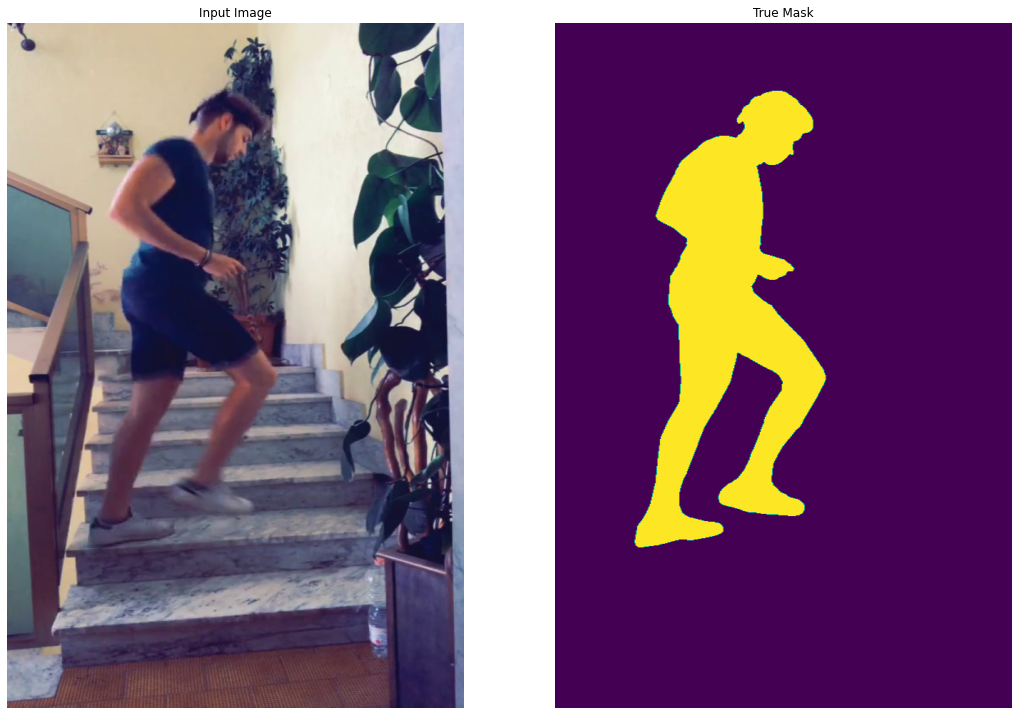

In [ ]:
for image, mask in dataset.skip(1).take(1):
    sample_image, sample_mask = image, mask

display_sample([sample_image, sample_mask])

# Load Model

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Data/task3/main_model2')
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=[mean_iou])

In [ ]:
model.evaluate(val)

262/262 [==============================] - 9568s 33s/step - loss: 0.0166 - mean_iou: 0.9602


[0.016638653352856636, 0.9601816534996033]

# Usage

In [ ]:
def add_mask(img : np.array, mask : np.array):
  """
  Adds a yellow mask to original image.

  Parameters
    ----------
    img : np.array
        Normalized image with pixel values from 0 to 1,0.

    mask : np.array
        Mask with pixel values from 0 to 255.

  Returns
    -------
    masked image : cv::Mat
        Image with yellow mask added.
        
  """
  img = (img*255).astype(np.uint8)
  mask = mask.astype(np.uint8)

  #create yellow mask
  mask_yellow = np.concatenate([mask*255,mask*255,mask*0],axis=2)

  #create mask of a person
  mask_person = cv2.bitwise_and(img,img,mask=mask)

  #create mask of backgroung
  mask_background = cv2.bitwise_and(img,img,mask=cv2.threshold(cv2.bitwise_not(mask), 0, 255, cv2.THRESH_OTSU)[1])
  
  #add yellow color to a human mask
  dst = cv2.addWeighted(mask_person, 0.6, mask_yellow, 0.4, 0.0)
 
  #add human mask and background mask to ger resulted image
  return cv2.add(dst,mask_background)

def display_segmentation(img,true_mask,predicted_mask):
  """
    Parameters
    ----------
    img : np.array
        Normalized image with pixel values from 0 to 1,0.

    true_mask : np.array
        Mask with pixel values from 0 to 255.

    true_mask : np.array
        Predicted mask with pixel values from 0 to 255.
  """
  true_mask_segmentation = add_mask(img,true_mask)
  pred_mask_segmentation = add_mask(img,predicted_mask)
  display_sample([img, true_mask_segmentation,pred_mask_segmentation])

In [ ]:
for image, mask in val.take(1):
    sample_image, sample_mask = image, mask
display_sample([sample_image[0], sample_mask[0], model(sample_image)[0][:,:,1].numpy().reshape((960,640,-1))])

In [ ]:
img, mask, pr_mask =sample_image[0], sample_mask[0],model(sample_image)[0][:,:,1].numpy().reshape((960,640,-1)) > 0.5

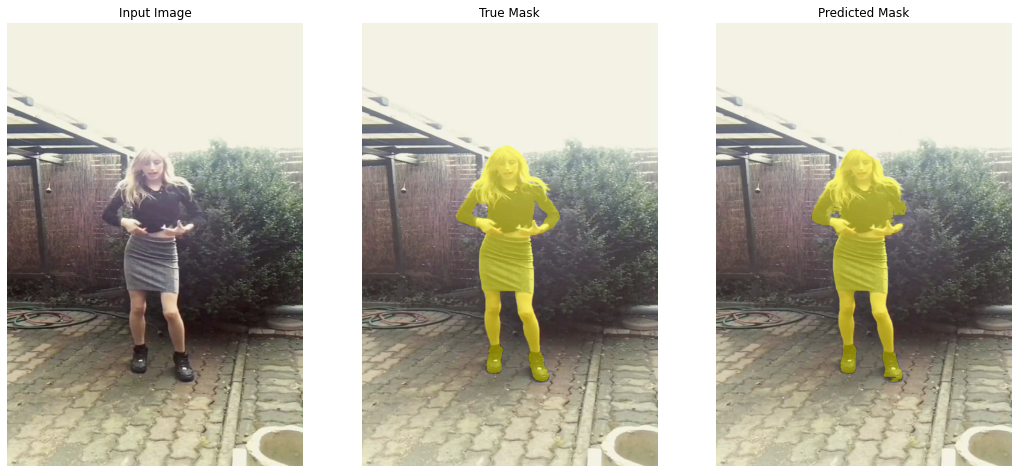

In [ ]:
display_segmentation(img.numpy(),mask.numpy(),pr_mask)

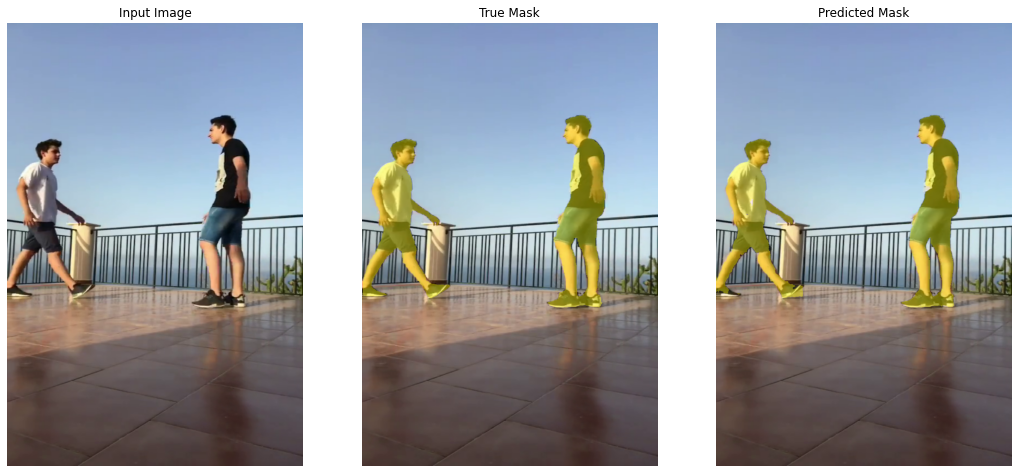

In [ ]:
display_segmentation(sample_image[1].numpy(), sample_mask[1].numpy(), model(sample_image)[1][:,:,1].numpy().reshape((960,640,-1)) > 0.5)
